# Individual Project
By Jeff Akins

#### ![EV Charging Station](https://i.insider.com/6042a8ac44d8e300117b9655?width=1200&format=jpeg)

## Exploring the State of the Electric Vehicle Charging Network within the U.S.
The world's methods of transportation are evolving, not only here in the United States, but globally. The EU recently proposed a mandate that all new vehicles be emissions free after 2035. In the U.S., the Biden administrations wants half of all new vehicles to be purely electric by 2030. Regardless of the mandates, buyers may be choosing to purchase EVs over their traditional internal combustion engine (ICE) counterparts in the upcoming years. No longer do you have to choose between the environment or the car that you want to drive. Many new EVs are surpassing comparable ICE vehicles in both speed, handling, and overall capability and new models of EVs are being introduced on a regular basis.

So, with all these new EV coming online, is the charging infrastructure keeping up? Buyers may be asking themselves, how many charging stations will be nearby if I need one? If I decide to go on a road trip, how difficult will it be to find an open charging station? I will try and answer these questions using a bit of machine learning to show the state of the charging networks now and the predicted growth over the next several years.

So, let's begin...

##### Imports:

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
import pandas.plotting

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import modeling as md
import wrangle as w
import warnings
warnings.filterwarnings('ignore')

### Data Acquisition: 
You can find the original dataset file [here](https://catalog.data.gov/dataset/alternative-fueling-station-locations-422f2/resource/341957d8-daf6-4a38-ab1d-8ec1bc21cfb9) on data.gov

In [2]:
csv_file_name = 'alternative-fuel-stations-2021-csv-3.csv'
ev = w.clean_ev(csv_file_name)

### Data Preparation:
The following steps were taken to clean the data:
- Dropped all rows that were not "electric" charging stations
- Dropped all columns with over 1000 null values
- Dropped an additional 12 columns that would not be used for this project
- Changed the pricing column to only include 'free' or 'cost' in the rows
- Filled the EV connector types nulls with the most common connector type of 'J1772'
- Fill EV Network nulls with most common 'non network' label
- Added values for 2 missing longitude values based on city location
- Renamed columns for ease of referencing and use with pandas
- Converted date columns to pandas datetime type
- Added a column for year that the charging station was opened
- Converted all 'count' columns into 'int' type and filled nulls with 0
- Replaced 'Public w/descriptor' with just 'Public' in group_access_code column
- Replaced 'Private w/descriptor' with just 'Private' in group_access_code column
- Dropped stations (rows) that are labeled as 'planned' and not yet accessible in the group_access_code column

Results are below:

In [3]:
ev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47006 entries, 0 to 47005
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   fuel_code               47006 non-null  object        
 1   station_name            47006 non-null  object        
 2   address                 47006 non-null  object        
 3   city                    47006 non-null  object        
 4   state                   47006 non-null  object        
 5   zip                     47006 non-null  object        
 6   group_access_code       47006 non-null  object        
 7   level1_evse_num         47006 non-null  int64         
 8   level2_evse_num         47006 non-null  int64         
 9   ev_dc_fast_count        47006 non-null  int64         
 10  ev_network              47006 non-null  object        
 11  lat                     47006 non-null  float64       
 12  long                    47006 non-null  float6

In [4]:
ev.head(2)

,fuel_code,station_name,address,city,state,zip,group_access_code,level1_evse_num,level2_evse_num,ev_dc_fast_count,ev_network,lat,long,update_date,open_date,connector_type,pricing,year_opened,total_chargers,rolling_total_chargers
0,ELEC,Los Angeles Convention Center,1201 S Figueroa St,Los Angeles,CA,90015,Public,0,12,0,Non-Networked,34.040539,-118.271387,2021-03-11,1995-08-30,J1772,Cost,1995,12,12
1,ELEC,State Capitol Parking Garage,1303 10th St,Sacramento,CA,95814,Private,0,9,0,Non-Networked,38.576769,-121.495022,2021-03-11,1996-10-15,J1772,Cost,1996,9,21


### Initial Plots:
To gain a visual understanding of the overall dataset

In [ ]:
plt.figure(figsize=(11,8))
sns.scatterplot(x='open_date', y='total_chargers', data=ev)
plt.title('Scatter Plot of the Number of New Chargers Installed by Open Date')
plt.xlabel('Charger Station Open Date')
plt.ylabel('Number of Chargers Installed')
plt.show()

In [ ]:
plt.figure(figsize=(11,8))
sns.scatterplot(x='long', y='lat',hue='group_access_code', data=ev)
plt.title('Plot of EV Charger Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Access')
plt.show()

In [ ]:
plt.figure(figsize=(16,8))
sns.lineplot(x='open_date', y='rolling_total_chargers', data=ev)
plt.title('Plot of the Sum of New Chargers over Time')
plt.xlabel('Charger Station Open Date')
plt.ylabel('Sum of Chargers Installed')
plt.show()

### Exploration:

##### Data Split:

In [5]:
ev = ev[['open_date', 'total_chargers']]


In [6]:
ev.head()

,open_date,total_chargers
0,1995-08-30,12
1,1996-10-15,9
2,1996-10-15,3
3,1997-07-30,1
4,1997-08-30,3


In [7]:
ev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47006 entries, 0 to 47005
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   open_date       47006 non-null  datetime64[ns]
 1   total_chargers  47006 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 734.6 KB


In [8]:
ev = ev.set_index('open_date')

In [9]:
ev = ev.resample('6M').sum()

In [10]:
ev.head()

,total_chargers
open_date,
1995-08-31,12
1996-02-29,0
1996-08-31,0
1997-02-28,12
1997-08-31,30


In [11]:
ev = ev['2010':]

<AxesSubplot:xlabel='open_date'>

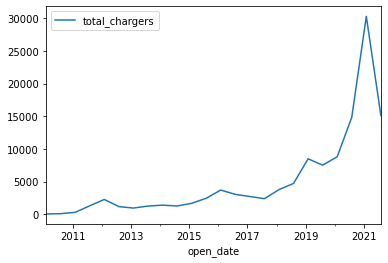

In [12]:
ev.plot()

In [13]:
# compute num of rows that are 50% of total rows and assign to variable train_size
train_size = int(len(ev) * .5)

# compute num of rows that are 30% of total rows and assign to variable validate_size
validate_size = int(len(ev) * .3)

# make test_size the number of rows remaining (test_size = total # of rows - train_size - validate_size)
test_size = int(len(ev) - train_size - validate_size)

# compute the row number at which the switch from validate to test happens. 
validate_end_index = train_size + validate_size

# split into train, validation, test
train = ev[: train_size]
validate = ev[train_size : validate_end_index]
test = ev[validate_end_index : ]

In [14]:
# To see the split:
print('Train:', len(train), ' Validate:', len(validate), ' Test:', len(test))

Train: 12  Validate: 7  Test: 5


In [ ]:
train

In [ ]:
plt.figure(figsize=(16,8))
sns.lineplot(x='open_date', y='rolling_total_chargers', data=train)
sns.lineplot(x='open_date', y='rolling_total_chargers', data=validate)
sns.lineplot(x='open_date', y='rolling_total_chargers', data=test)
plt.title('Plot of the Sum of New Chargers over Time')
plt.xlabel('Charger Station Open Date')
plt.ylabel('Sum of Chargers Installed')
plt.show()

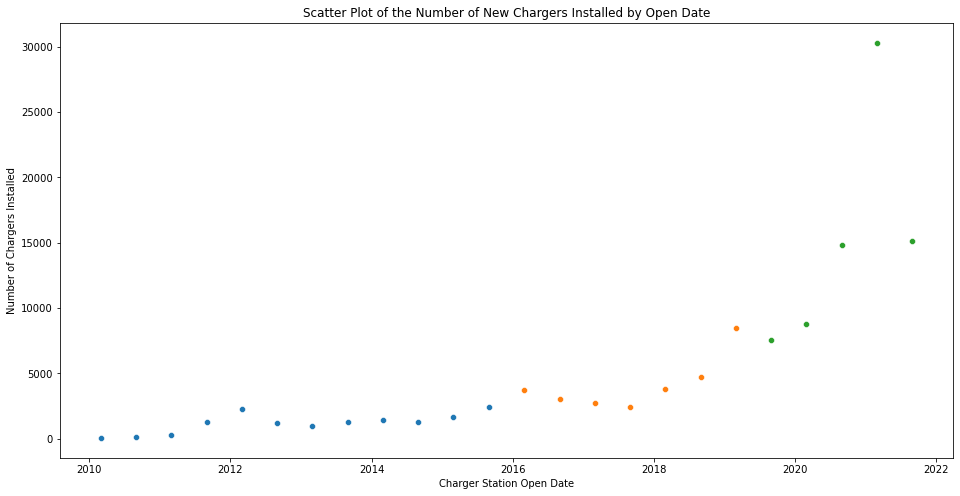

In [15]:
plt.figure(figsize=(16,8))
sns.scatterplot(x='open_date', y='total_chargers', data=train)
sns.scatterplot(x='open_date', y='total_chargers', data=validate)
sns.scatterplot(x='open_date', y='total_chargers', data=test)
plt.title('Scatter Plot of the Number of New Chargers Installed by Open Date')
plt.xlabel('Charger Station Open Date')
plt.ylabel('Number of Chargers Installed')
plt.show()

##### Findings: 
Most of the EV charging stations within the US have been added since 2010 with an exponential increase over the last five years.

In [ ]:
#train = train.set_index('open_date')
#validate = validate.set_index('open_date')
#test = test.set_index('open_date')

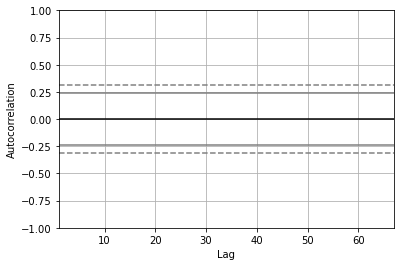

In [30]:
pd.plotting.autocorrelation_plot(train.resample('M').mean())
plt.show()

### Modeling:

In [ ]:
roller = train['rolling_total_chargers'].rolling(60).mean()
roller = pd.DataFrame(roller)
compare_roller = pd.concat([train.index, roller], axis=1)
compare_roller

In [ ]:
# Moving Average Plot
plt.figure(figsize=(16,8))
sns.lineplot(x=train.index, y='rolling_total_chargers', data=train)
sns.lineplot(x='open_date', y='rolling_total_chargers', data=compare_roller)

plt.title('Plot of the Sum of New Chargers over Time')
plt.xlabel('Charger Station Open Date')
plt.ylabel('Sum of Chargers Installed')
plt.show()

In [16]:
train.head()

,total_chargers
open_date,
2010-02-28,39
2010-08-31,93
2011-02-28,295
2011-08-31,1296
2012-02-29,2266


In [21]:
model = Holt(train['total_chargers'], exponential = True)
model = model.fit(smoothing_level = .1, 
                  smoothing_slope = .1, 
                  optimized = False)
yhat_items = model.predict(start = validate.index[0], 
                           end = validate.index[-1])
yhat = round(yhat_items, 2)

In [27]:
yhat = pd.DataFrame(yhat)

In [29]:
yhat

,0
2016-02-29,9.012771e+05
2016-08-31,1.983490e+06
2017-02-28,4.365178e+06
2017-08-31,9.606688e+06
2018-02-28,2.114197e+07
2018-08-31,4.652831e+07
2019-02-28,1.023974e+08


ValueError: Could not interpret value `open_date` for parameter `x`

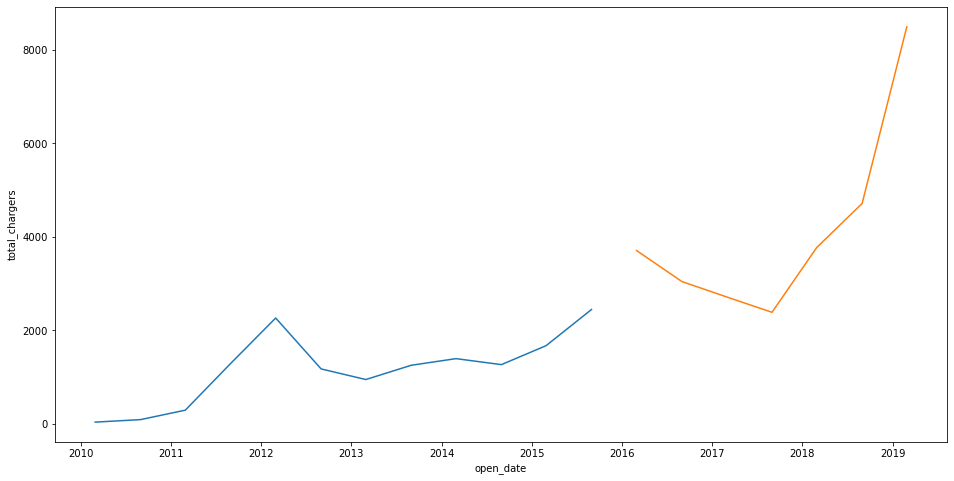

In [28]:
# Holt Plot
plt.figure(figsize=(16,8))
sns.lineplot(x='open_date', y='total_chargers', data=train)
sns.lineplot(x='open_date', y='total_chargers', data=validate)
sns.lineplot(x='open_date', y='total_chargers', data=yhat)

plt.title('Plot of the Sum of New Chargers over Time')
plt.xlabel('Charger Station Open Date')
plt.ylabel('Sum of Chargers Installed')
plt.show()

#### Previous Year

In [ ]:
len(validate)

In [ ]:
yhat_df = train['2015'] + train.diff(365).mean()
yhat_df.index = validate.index

In [ ]:
model = Holt(train.rolling_total_chargers, exponential = True)
# fit the model providing the alpha/smoothing level and beta/smoothing slope
model = model.fit(smoothing_level = .1, 
                  smoothing_slope = .1,
                  optimized = False
                 )
# predict/forecast providing the start and end dates
yhat = model.predict(start = validate.index[0], end = validate.index[-1])

yhat_df = round(yhat, 2)